# PyTorch Layer 이해하기

# 예제 불러오기

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [54]:
batch_size=1

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

In [4]:
image, label = next(iter(train_loader))

In [5]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

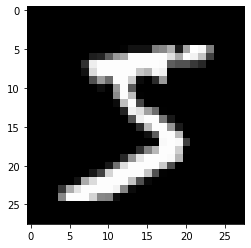

In [6]:
plt.imshow(image[0, 0, :, :], 'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

#### nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

In [7]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [8]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [9]:
conv_layer = nn.Conv2d(1,3,5,1).to(torch.device('cpu'))
conv_layer

Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [10]:
weight = conv_layer.weight
weight

Parameter containing:
tensor([[[[-0.0305, -0.0479, -0.1166,  0.1458, -0.0355],
          [ 0.0519,  0.0856,  0.0408,  0.1998,  0.0684],
          [-0.0313,  0.1652, -0.0495, -0.0876,  0.1553],
          [ 0.0880,  0.0967, -0.0459,  0.0105,  0.1432],
          [ 0.1270, -0.1263,  0.0822,  0.1490, -0.0705]]],


        [[[ 0.1299,  0.1215,  0.1600, -0.0496, -0.1771],
          [ 0.0933,  0.1472,  0.0026,  0.1015, -0.0359],
          [-0.0612, -0.1031, -0.1352, -0.0100,  0.1689],
          [-0.0568, -0.0279,  0.1949,  0.1938,  0.0095],
          [ 0.0284,  0.0346, -0.1374, -0.0032, -0.0541]]],


        [[[ 0.0326, -0.0883, -0.0666,  0.0786, -0.1708],
          [ 0.0611, -0.0897, -0.0747,  0.0191,  0.0187],
          [-0.0491, -0.1515,  0.1966, -0.0307,  0.0955],
          [ 0.1933, -0.1511,  0.0338, -0.1326, -0.0314],
          [ 0.0156,  0.1111,  0.1397,  0.0608,  0.1341]]]], requires_grad=True)

In [11]:
weight.shape

torch.Size([3, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [12]:
num_weight = weight.detach().numpy()

In [14]:
num_weight.shape

(3, 1, 5, 5)

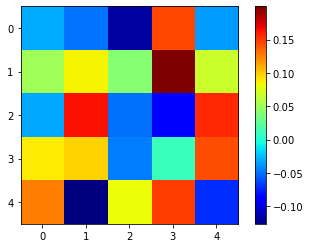

In [16]:
plt.imshow(num_weight[0, 0, :, :], 'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [17]:
output_data = conv_layer(image)

In [18]:
output_data.shape

torch.Size([1, 3, 24, 24])

In [21]:
output = output_data.data.cpu().numpy()

In [23]:
output.shape

(1, 3, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [25]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

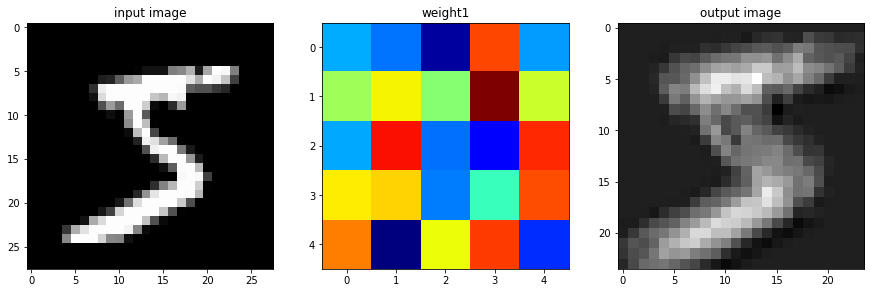

In [30]:
plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title("input image")
plt.imshow(np.squeeze(image_arr), 'gray')

plt.subplot(132)
plt.title("weight1")
plt.imshow(num_weight[0,0,:,:], 'jet')

plt.subplot(133)
plt.title('output image')
plt.imshow(output[0,0,:,:], 'gray')

plt.show()

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [31]:
image.shape

torch.Size([1, 1, 28, 28])

In [33]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [35]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

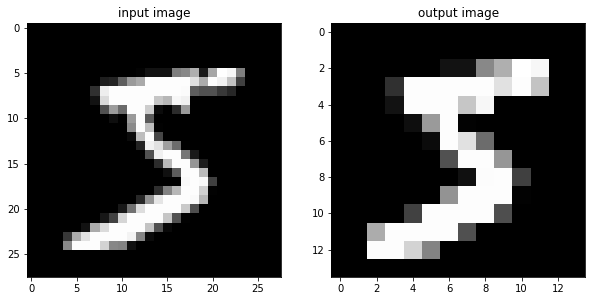

In [36]:
plt.figure(figsize=(10, 15))
plt.subplot(121)
plt.title("input image")
plt.imshow(np.squeeze(image_arr), 'gray')

plt.subplot(122)
plt.title("output image")
plt.imshow(np.squeeze(pool_arr), 'gray')

plt.show()

### Linear

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [38]:
flatten = image.view(1, -1)
flatten.shape

torch.Size([1, 784])

In [41]:
linear_layer = nn.Linear(flatten.shape[1], 10)(flatten)
linear_layer.shape

torch.Size([1, 10])

In [42]:
linear_layer

tensor([[-0.2379, -0.0205, -0.0965, -0.0830, -0.0589,  0.0040,  0.2131, -0.0738,
         -0.5230,  0.0264]], grad_fn=<AddmmBackward>)

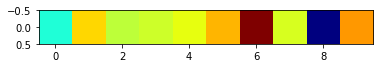

In [43]:
plt.imshow(linear_layer.detach().numpy(), 'jet')
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [44]:
with torch.no_grad():
    flatten = image.view(1, -1)
    linear_layer = nn.Linear(flatten.shape[1], 10)(flatten)
    softmax = F.softmax(linear_layer, dim=1)

In [45]:
softmax

tensor([[0.1019, 0.1105, 0.1136, 0.0966, 0.0861, 0.1150, 0.0991, 0.0879, 0.1074,
         0.0820]])

In [46]:
np.sum(softmax.numpy())

1.0

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.fc1 = nn.Linear(4*4*50, 500) # print문을 보고 확인
        self.fc2 = nn.Linear(500,10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) # kernel, stride
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        print(x.shape)
        
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

- Image를 Model에 넣어서 결과 확인

In [56]:
model = Net()

In [57]:
result = model.forward(image)

torch.Size([1, 50, 4, 4])


In [58]:
result

tensor([[-2.3506, -2.2674, -2.2922, -2.3800, -2.2623, -2.2975, -2.3057, -2.2850,
         -2.3694, -2.2267]], grad_fn=<LogSoftmaxBackward>)

In [60]:
model.conv1(image).shape

torch.Size([1, 20, 24, 24])